# Multilayer perceptron
In this notebook, a multilayer perceptron (MLP) model is implemented in Pytorch.
It is build so that the user can input the desired layer sizes as an argument to the model. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Select device which you are going to use for training
device = torch.device("cuda:0")
# device = torch.device("cpu")

## Load data
The data set that is used is the [**Wine Quality Data Set**](https://archive.ics.uci.edu/ml/datasets/Wine+Quality).

In [3]:
red_wine = pd.read_csv("../data/winequality-red.csv", delimiter=';')
white_wine = pd.read_csv("../data/winequality-white.csv", delimiter=';')
data = pd.concat([red_wine, white_wine])
data.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


The attribute `quality` is our dependent variable that we are trying to predict, so it will be dropped from the features.

In [4]:
features = torch.Tensor(data.loc[:,data.columns!='quality'].values)
labels = torch.Tensor(data.quality.values)
features.shape, labels.shape

(torch.Size([6497, 11]), torch.Size([6497]))

In [5]:
labels.unique()

tensor([3., 4., 5., 6., 7., 8., 9.])

We transform the labels so that this becomes a binary classification problem:
- `y=0` if the wine quality is deemed less than 7,
- `y=1` if the wine quality is deemed greater or equal than 7.

In [6]:
labels = (labels >= 7).float().view(-1,1)

## Create train and test splits
20% of the data will be used for testing, the rest will be used for training.
The split will be performed by randomly subsampling from the the data set.

In [7]:
(train_feats, test_feats, 
 train_labels, test_labels) = train_test_split(features, labels, test_size=.2,
                                           random_state=42)

In [8]:
# Check shapes
print(f"Features : {train_feats.shape}, {test_feats.shape}")
print(f"Labels : {train_labels.shape}, {test_labels.shape}")

Features : torch.Size([5197, 11]), torch.Size([1300, 11])
Labels : torch.Size([5197, 1]), torch.Size([1300, 1])


## Standardize the features
In order to facilitate the optimization problem, we will standardize the features, that is:
- **zero mean**: the mean is subtracted from the data point along each feature,
- **unit variance**: each feature is divided by its standard deviation.
<div class="alert alert-block alert-info">
It is important to notice that this preprocessing step should be performed using the statistics obtained in the training set only.
Otherwise, we would suffer <b>data leakage</b>: information from the test set would be used, which would not be possible in the real scenario.
</div>

In [9]:
scaler = StandardScaler()
scaler.fit(train_feats)
train_feats = scaler.transform(train_feats)
test_feats = scaler.transform(test_feats)

In [10]:
# Check scaling
np.mean(train_feats[:,0])

2.645565121600527e-16

In [11]:
# Transform features back to torch tensors
train_feats = torch.Tensor(train_feats)
test_feats = torch.Tensor(test_feats)
train_feats.shape, test_feats.shape

(torch.Size([5197, 11]), torch.Size([1300, 11]))

## Build MLP classifier
Here, we build the MLP model.

In [12]:
class MLP(nn.Module):
    def __init__(self, sizes, activation_fn=torch.tanh):
        """Multilayer perceptron with an arbitrary number of layers.
        
        Args:
          sizes (list): Number of units in each layer including the input and the output layer:
                         [n_inputs, n_units_in_hidden_layer1, ..., n_units_in_hidden_layerN, n_outputs]
          activation_fn (callable): An element-wise function used in every layer except in the last one.
        """
        super(MLP, self).__init__()
        self.activation_fn = activation_fn
        self.sizes = sizes
        self.linears = nn.ModuleList([nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)])
        
    def forward(self, x):
        for i, layer in enumerate(self.linears):
            if i != len(self.linears)-1:
                x = self.activation_fn(layer(x))
            else:
                out = torch.sigmoid(layer(x))
        return out

## Model training

In [13]:
# Compute the accuracy of the model on the given dataset
def compute_accuracy(model, inputs, targets):
    with torch.no_grad():
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = (model.forward(inputs) > 0.5).float()
        accuracy = (outputs == targets).sum().float() / targets.numel()
        return accuracy

In [14]:
# Create the model
model = MLP([11, 150, 100, 50, 1])
model.to(device)

MLP(
  (linears): ModuleList(
    (0): Linear(in_features=11, out_features=150, bias=True)
    (1): Linear(in_features=150, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [15]:
train_acc = []
train_feats, train_labels = train_feats.to(device), train_labels.to(device)
for iter in range(2000):
    model.zero_grad()
    out = model(train_feats)
    loss = F.binary_cross_entropy(out, train_labels)
    loss.backward()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    if iter % 100 == 0:
        train_acc_iter = compute_accuracy(model, train_feats, train_labels)
        train_acc.append(train_acc_iter)
    optimizer.step()

Text(0.5, 1.0, 'Evolution of training accuracy')

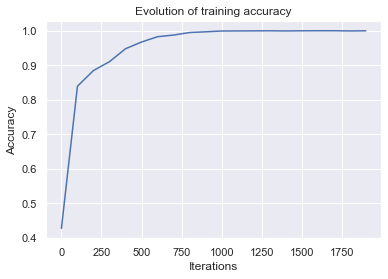

In [17]:
plt.plot(np.arange(0, 2000, 100), train_acc)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Evolution of training accuracy")

In [18]:
test_acc = compute_accuracy(model, test_feats, test_labels)
print(f"The model converged to a training accuracy of {train_acc[-1]}.")
print(f"The model achieved a test accuracy of {test_acc}")

The model converged to a training accuracy of 0.9996151924133301.
The model achieved a test accuracy of 0.8715384602546692


# Conclussion
Compared to the previous MLP model, we achieve almost perfect performance on the traning set, which yield a slightly better performance on the test set. 
It is possible this improvement comes from the fact that this model is deeper than the previous one.

As we said before, regularization is needed in order to improve the test performance.

